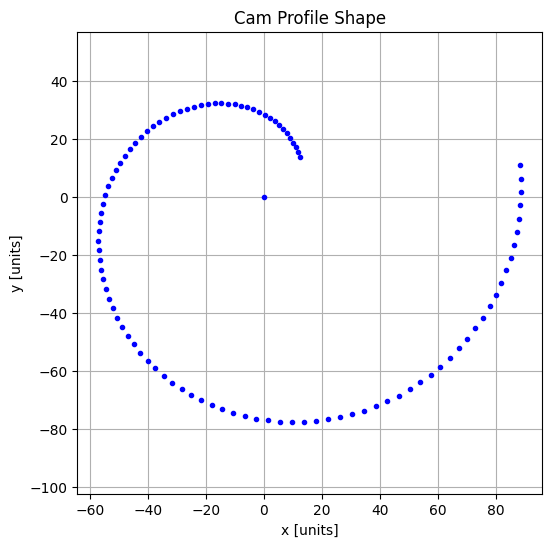

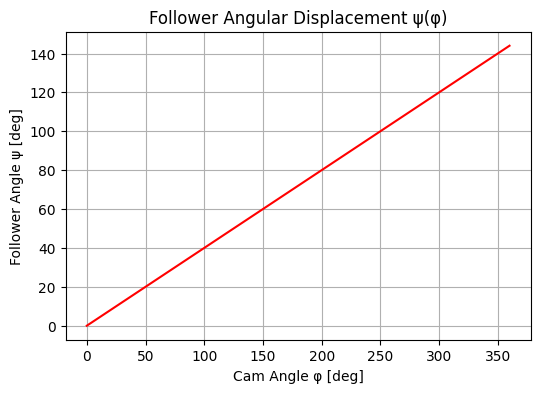

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def make_psi_data(phi_array, psi_values):
    """
    Build list of (phi, psi) tuples from arrays of φ (cam angle) and ψ (follower angle).
    
    Parameters:
      phi_array   : array-like — cam angles [rad]
      psi_values  : array-like — follower angles [rad], same length as phi_array
    
    Returns:
      data_list   : list of tuples (φ_i, ψ_i)
    """
    return list(zip(phi_array, psi_values))


def cam_profile_from_data(psi_data, alpha, l, psi0=0.0, IP=1, IW=1):
    """
    Compute cam profile (x, y) from discrete data (φ_i, ψ_i) using inversion method.
    
    Parameters:
      psi_data   : list of tuples (φ, ψ) where φ [rad], ψ [rad]
      alpha      : float — distance OA
      l          : float — follower length AB
      psi0       : float — initial follower angle [rad]
      IP         : +1 or -1 — orientation indicator
      IW         : +1 or -1 — cam rotation direction
    Returns:
      x, y, phi, psi   : numpy arrays of coordinates and angles
    """
    phi = np.array([item[0] for item in psi_data])
    psi = np.array([item[1] for item in psi_data])
    
    xk = alpha - l * np.cos(IP * (psi + psi0))
    yk = l * np.sin(IP * (psi + psi0))
    
    c = np.cos(IW * phi)
    s = np.sin(IW * phi)
    x = c * xk - s * yk
    y = s * xk + c * yk
    
    return x, y, phi, psi


# Example usage:
alpha = 50.0       # units (e.g., mm)
l     = 40.0       # units
psi0  = np.deg2rad(20.0)
IP    = 1
IW    = 1

phi_array = np.linspace(0, 2*np.pi, 100)
# Example motion: simple harmonic
#psi_values = 0.4 * np.sin(phi_array)   # in radians
psi_values = 0.4 * phi_array   # in radians

# Generate data list
psi_data = make_psi_data(phi_array, psi_values)

# Compute profile
x, y, phi, psi = cam_profile_from_data(psi_data, alpha, l, psi0, IP, IW)

# Plot cam profile
plt.figure(figsize=(6,6))
plt.plot(x, y, '.b')
plt.plot(0, 0, '.b')
plt.axis('equal')
plt.title("Cam Profile Shape")
plt.xlabel("x [units]")
plt.ylabel("y [units]")
plt.grid(True)
plt.show()

# Plot follower motion ψ vs φ
plt.figure(figsize=(6,4))
plt.plot(np.degrees(phi), np.degrees(psi), '-r')
plt.title("Follower Angular Displacement ψ(φ)")
plt.xlabel("Cam Angle φ [deg]")
plt.ylabel("Follower Angle ψ [deg]")
plt.grid(True)
plt.show()


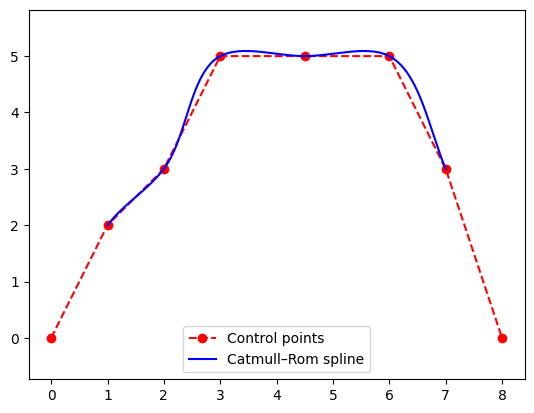

In [20]:
import numpy as np

def catmull_rom_spline(points, n_points=100, alpha=0.8):
    """
    Generate a smooth Catmull-Rom spline through given 2D points.

    Parameters
    ----------
    points : list of (x, y)
        Control points the spline must pass through.
    n_points : int
        Number of interpolated points between each pair of control points.
    alpha : float
        Tension parameter (0–1). 
        0.5 = centripetal (prevents loops), 0 = uniform, 1 = chordal.

    Returns
    -------
    np.ndarray
        Array of shape (N, 2) representing the smooth path.
    """
    points = np.asarray(points)
    if len(points) < 4:
        raise ValueError("Need at least 4 points for Catmull-Rom spline")

    # Helper: compute parameter t based on chord length
    def tj(ti, pi, pj):
        return ((np.linalg.norm(pj - pi)) ** alpha) + ti

    curve = []
    for i in range(len(points) - 3):
        p0, p1, p2, p3 = points[i:i+4]

        # Parametrize based on distances
        t0 = 0
        t1 = tj(t0, p0, p1)
        t2 = tj(t1, p1, p2)
        t3 = tj(t2, p2, p3)

        # Interpolate between t1 and t2
        t_vals = np.linspace(t1, t2, n_points)
        for t in t_vals:
            A1 = (t1 - t)/(t1 - t0)*p0 + (t - t0)/(t1 - t0)*p1
            A2 = (t2 - t)/(t2 - t1)*p1 + (t - t1)/(t2 - t1)*p2
            A3 = (t3 - t)/(t3 - t2)*p2 + (t - t2)/(t3 - t2)*p3

            B1 = (t2 - t)/(t2 - t0)*A1 + (t - t0)/(t2 - t0)*A2
            B2 = (t3 - t)/(t3 - t1)*A2 + (t - t1)/(t3 - t1)*A3

            C  = (t2 - t)/(t2 - t1)*B1 + (t - t1)/(t2 - t1)*B2
            curve.append(C)

    return np.array(curve)




import matplotlib.pyplot as plt

# Example control points
points = [(0,0), (1,2), (2,3), (3,5), (4.5, 5), (6,5), (7,3), (8,0)]
curve = catmull_rom_spline(points, n_points=50)

# Plot control points and curve
plt.plot(*zip(*points), 'ro--', label='Control points')
plt.plot(curve[:,0], curve[:,1], 'b', label='Catmull–Rom spline')
plt.legend()
plt.axis('equal')
plt.show()

